# Metropolis-adjusted Langevin algorithm Implementations for nonlinear regression with neural network

The Metropolis-adjusted Langevin algorithm (MALA) is a Markov Chain Monte Carlo (MCMC) method for obtaining random samples from a probability distribution for which direct sampling is difficult. MALA uses a combination of two mechanisms to generate the states of a random walk
- New states are proposed using Langevin dynamics: use evaluations of the gradient of the target probability density function
- Proposals are accepted or rejected using Metropolis-Hasting algorithm

The notebook also contains the implementation of the unadjusted Langevin algorithm (ULA).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.stats import multivariate_normal as mvn

In [2]:
class NonlinearSimulator:
    
    def __init__(self):
        self.X = None
        self.y = None
        self.y_mean = None

    def run(self):
        # create nonlinear feature maps for 6 input variables
        n = 500

        # The ground truth intercept and weights
        w_true = [0.5, 1.5, -1.0, 0.7, 1.3, 2.0, 1.0]   
        sigma = 0.5

        # Create Data x
        x1 = np.random.uniform(-1, 1, n)
        x2 = np.random.uniform(-1, 1, n)
        x3 = np.random.uniform(-1, 1, n)
        x4 = x1 * x2                                      
        x5 = x2 ** 2                                      
        x6 = np.cos(x1)                                       

        # Create Matrix
        X = [x1, x2, x3, x4, x5, x6]

        
        Y_mean = w_true[0]*x1 + w_true[1]*x2 + w_true[2]*x3 + w_true[3]*x4 + w_true[4]*x5 + w_true[5]*x6 + w_true[6]
        
        
        self.X = np.array(X).T
        self.y_mean = np.array(Y_mean)
        
        self.y = self.y_mean + np.random.normal(0, sigma, size=n)

In [3]:
# Helper function for collecting nn gradient into a vector
def collect_grads(model):
    return torch.cat([p.grad.data.view(1, -1) for p in model.parameters()], dim=-1)

# Helper function for computing sizes of all nn parameters
def get_param_sizes(model):
    return [p.reshape(-1).size()[0] for p in model.parameters()]

# Helper function for writing the updated weights
def update_params(new_params, model, param_sizes):
    start_index = 0
    for i, p in enumerate(model.parameters()):
        end_index = start_index + param_sizes[i]
        source_tensor = new_params[:, start_index:end_index].reshape(p.shape)
        p.data = source_tensor
        start_index = end_index

def collect_params(model):
    return torch.cat([p.data.view(1, -1) for p in model.parameters()], dim=-1)

def print_params(model):
    for p in model.parameters():
        print(p.data)

In [4]:
# Helper function for constructing potential energy function
def create_U(X, y, sigma_0):
    
    def U(nn, tau):
        fit = -0.5 * tau * ((y - nn(X)) ** 2).sum()
        params = collect_params(nn)
        l2 = (params ** 2).sum()
        reg = -l2 / (2 * sigma_0 ** 2)
        return fit + reg
    
    return U

# Helper function for constructing gradient of potential energy function
def create_grad_U(X, y, sigma_0):
    
    def grad_U(nn, tau, U):
        PE = U(nn, tau)
        nn.zero_grad()
        PE.backward()
        grad = collect_grads(nn)
        return grad
    
    return grad_U


# Helper function for constructing conditional distribution for tau
def create_p_tau(X, y, alpha_0, beta_0, N):
    alpha = alpha_0 + N / 2
    
    def p_tau(tau, nn):
        z = y - nn(X)
        beta = (beta_0 + 0.5 * z.T @ z).detach().numpy().item()
        return np.random.gamma(alpha, 1 / beta)
    
    return p_tau

In [5]:
class MLP(nn.Module):
    def __init__(self, num_inputs):
        super(MLP, self).__init__()
        
        self.layer_1 = nn.Linear(num_inputs, 10)
        self.output_layer = nn.Linear(10, 1)
    
    def forward(self, x):
        x = torch.sigmoid(self.layer_1(x))
        return self.output_layer(x)

In [6]:
# p(beta | X, y sigma2)
def LOGPOST(mlp, beta, X, y, sigma2, beta0, Sigma2_0):
    # print((y_tensor - mlp(X)).shape, ((y_tensor - mlp(X) / sigma2).shape)
    #print("Forward", mlp(X), "y:", y)
    log_likelihood = (-0.5 * (y.T - mlp(X)).T @ (y.T - mlp(X)) / (2 * sigma2)).squeeze()
    log_prior_beta = (-0.5 * (beta - beta0).reshape(1, -1) @ np.linalg.inv(Sigma2_0) @ (beta - beta0).reshape(-1, 1)).squeeze()
    
    #print("Likelihood", log_likelihood, log_prior_beta)
    return log_likelihood + log_prior_beta

#Work in log form for numeric stability
def ACCPT(mlp, beta_new, beta_old, x, y, sigma2, beta0, Sigma2_0, reverse_proposal_density, proposal_density):
    PN = LOGPOST(mlp, beta_new, x, y, sigma2, beta0, Sigma2_0)
    PO = LOGPOST(mlp, beta_old, x, y, sigma2, beta0, Sigma2_0)
    ratio = np.exp(PN + np.log(reverse_proposal_density) - PO - np.log(proposal_density))

    #print("Ratio: ", ratio, "PN", PN, "PO", PO, "reverse pd", np.log(reverse_proposal_density), "pd", np.log(proposal_density))
    return min(1, ratio)

In [7]:
class MALA:
    
    def __init__(self, X, y, mlp, method):
        # True weight(s)
        #self.w = np.array([1.5, -1.0, 0.7])

        # Input dimensionality
        #self.d = self.w.size

        # True intercept
        #self.b = 0.5
        
        # Preconditioner matrix
        self.no_params = sum(get_param_sizes(mlp))
        self.M = torch.tensor(np.identity(self.no_params)).float()
        
        # Step size for Euler-Maruyama
        self.delta_t = 0.001
        
        # Standard deviation of weight prior
        self.sigma_0 = 5.0
        
        # True standard deviation
        self.sigma = 0.5
        
        self.X = X
        self.y = y
        
        self.beta0 = np.zeros(self.no_params)
        self.beta = np.zeros(self.no_params)
        
        # TODO: Should be create a sampling like in Gibbs
        #self.sigma2 = 0.5
        
        # Shape parameter of noise prior
        self.a0 = 0.001
        
        # Rate parameter of noise prior
        self.b0 = 0.001
        
        # L2 Loss calculation
        self.X_tensor = torch.tensor(X, dtype=torch.float32, requires_grad=False)
        self.y_tensor = torch.tensor(y, dtype=torch.float32, requires_grad=False).view(1, -1)
        
        # Length of the chain
        self.chain_length = 10000
        
        # Number of discarded samples from beginning
        self.burn_in = 2000
        
        # Number of data points
        self.N = 500
        
        self.Sigma2_0 = self.sigma_0 ** 2 * np.identity(self.no_params)
        
        self.method = method
        
    
    def step(self, beta_old, sigma2, mlp, param_sizes):
        
        mlp.zero_grad()
        
        l2_0 = - (((self.y_tensor.T - mlp(self.X_tensor)) ** 2) / (2*sigma2)).sum()
        params = collect_params(mlp)
        l2 = (params ** 2).sum()
        reg = l2 / (2 * self.sigma_0 ** 2)
        l2_loss = l2_0 - reg
        
        l2_loss.backward()
        
        l2_loss_old = l2_loss.clone()
        
        with torch.no_grad():
            grad = collect_grads(mlp)
            
            proposal_mean = torch.squeeze(beta_old.T + 0.5 * self.delta_t * self.M @ grad.T )
            proposal_cov = self.M * self.delta_t 

            beta_proposed = np.random.multivariate_normal(mean=proposal_mean, cov=proposal_cov)
            beta_proposed = torch.tensor(beta_proposed, dtype=torch.float32, requires_grad=False).view(1,-1)
            
            proposal_density = mvn.pdf(beta_proposed.squeeze().detach().numpy(), 
                                       proposal_mean.squeeze().detach().numpy(), 
                                       proposal_cov.squeeze().detach().numpy())
            
            update_params(beta_proposed, mlp, param_sizes)
            
        if self.method == "ULA":
                return beta_proposed, 1
        elif self.method == "MALA":
        
            mlp.zero_grad()

            l2_0 = - (((self.y_tensor.T - mlp(self.X_tensor)) ** 2) / (2*sigma2)).sum()
            params = collect_params(mlp)
            l2 = (params ** 2).sum()
            reg = l2 / (2 * self.sigma_0 ** 2)
            l2_loss = l2_0 - reg

            l2_loss.backward()

            with torch.no_grad():
                grad = collect_grads(mlp)
                reverse_proposal_mean = (beta_proposed + 0.5 * (self.delta_t * self.M @ grad.T).T).squeeze()

                reverse_proposal_density = mvn.pdf(beta_old.squeeze().detach().numpy(), 
                                                   reverse_proposal_mean.squeeze().detach().numpy(), 
                                                   proposal_cov.squeeze().detach().numpy())

                #alpha = ACCPT(mlp, beta_proposed, beta_old, self.X_tensor, self.y_tensor, 
                #              sigma2, self.beta0, self.Sigma2_0, reverse_proposal_density, proposal_density)

                alpha = np.exp(l2_loss.detach().numpy().item() + np.log(reverse_proposal_density) - \
                               l2_loss_old.detach().numpy().item() - np.log(proposal_density))

                u = np.random.uniform()

                if u < alpha:
                    return beta_proposed, 1
                else:
                    update_params(beta_old, mlp, param_sizes)
                    return beta_old, 0
                
        else:
            raise NotimplementedError("Method must be ULA or MALA")
    
    
    def run(self, model, param_sizes, theta, tau):
        
        num_samples = self.chain_length - self.burn_in
        self.samples = np.zeros((num_samples, self.no_params + 1))
        acceptances = []
        
        for i in range(self.chain_length):
            theta, acceptance = self.step(theta, 1/tau, model, param_sizes)
            #print("Theta", theta, "Acceptance", acceptance)
            
            with torch.no_grad():
                update_params(theta.view(1,-1), model, param_sizes)
                tau = p_tau(tau, model)
    
            if i >= self.burn_in:
                j = i - self.burn_in
                self.samples[j, 0] = np.sqrt(1/tau)
                self.samples[j, 1:] = theta.detach().numpy().squeeze()
                acceptances.append(acceptance)
                
        acceptance_rate = np.array(acceptances).mean()
        
        return self.samples, acceptance_rate
    
    
    def plot(self):
        
        true_params = np.concatenate([[self.sigma], self.w, [self.b]], axis=0)
        
        num_params = self.no_params + 1
        plt.figure(figsize=(15, 5 * num_params))
        param_names = ["sigma"]
        
        for i in range(num_params - 2):
            param_names.append("weight " + str(i+1))
        param_names.append("intercept")
        
        for i in range(num_params):
            true_val = true_params[i]
            samples = self.samples[:, i]
            plt.subplot(num_params,2,i*2+1)
            y, _, _ = plt.hist(samples, bins=100, label="samples")
            max_y = int(np.max(y))
            plt.plot([true_val] * max_y, range(max_y), c="r", label="true value")
            plt.title("Histogram for {}".format(param_names[i]))
            plt.legend()
            plt.subplot(num_params,2,i*2+2)
            plt.plot(samples, label="chain")
            plt.plot([0, samples.size], [true_val, true_val], c="r", label="true value")
            plt.title("Trace plot for {}".format(param_names[i]))
            plt.legend()
            
        plt.show()

In [8]:
num_seeds = 5

simulator = NonlinearSimulator()
test_simulator = NonlinearSimulator()

mse_vals = np.zeros((num_seeds))
rmse_vals = np.zeros((num_seeds))
mae_vals = np.zeros((num_seeds))
mean_ess_vals = np.zeros((num_seeds))

for i in range(num_seeds):

    simulator.run()

    X = simulator.X
    y = simulator.y

    # Create helper functions
    X_tensor = torch.tensor(X, dtype=torch.float32, requires_grad=False)
    y_tensor = torch.tensor(y, dtype=torch.float32, requires_grad=False).view(-1, 1)

    alpha_0 = 0.001
    beta_0 = 0.001

    p_tau = create_p_tau(X_tensor, y_tensor, alpha_0, beta_0, N=500)

    # Compute number of MLP inputs from design matrix dimensions
    num_mlp_inputs = X.shape[-1]

    mlp = MLP(num_inputs=num_mlp_inputs)
    param_sizes = get_param_sizes(mlp)
    num_params = sum(param_sizes)

    chain = MALA(X, y, mlp, method="ULA")

    # Initialize chain
    theta = collect_params(mlp)
    tau = 1.0

    # Run chain
    samples, acceptances = chain.run(mlp, param_sizes, theta, tau)

    # Perform mse evaluation on test data
    test_simulator.run()

    test_X = test_simulator.X
    test_y = test_simulator.y

    X_tensor_test = torch.tensor(test_X, dtype=torch.float32, requires_grad=False)

    mean_weights = samples[:, 1:].mean(axis=0).reshape(1, -1)
    mean_weights_tensor = torch.tensor(mean_weights, dtype=torch.float32)
    update_params(mean_weights_tensor, mlp, param_sizes)
    y_pred = mlp(X_tensor_test)

    mse = ((y_pred.T - torch.tensor(test_simulator.y_mean).T) ** 2).mean().detach().numpy().item()
    
    rmse = np.sqrt(mse)
    
    mae = (torch.abs(y_pred.T - torch.tensor(test_simulator.y_mean).T)).mean().detach().numpy().item()
    
    mse_vals[i] = mse
    rmse_vals[i] = rmse
    mae_vals[i] = mae
    
    ess_all = []
    for j in range(num_params + 1):
        weights = samples[:, j]
        weights /= (weights ** 2).sum()
        autocorr = np.correlate(weights, weights, mode='full')
        autocorr = autocorr[autocorr.size // 2 :]
        ess = (chain.chain_length - chain.burn_in) / (1 + 2 * autocorr.sum())
        ess_all.append(ess)
        
    mean_ess = sum(ess_all) / len(ess_all)
    mean_ess_vals[i] = mean_ess
    
print(mse_vals)
print("mse: {}".format(mse_vals.mean()))
print(mse_vals.std())

print(rmse_vals)
print("rmse: {}".format(rmse_vals.mean()))
print(rmse_vals.std())

print(mae_vals)
print("mae: {}".format(mae_vals.mean()))
print(mae_vals.std())

print(mean_ess_vals)
print("ess: {}".format(mean_ess_vals.mean()))
print(mean_ess_vals.std())

[0.02630889 0.04603368 0.03126656 0.02338748 0.06693138]
mse: 0.038785597649958495
0.016087424690205868
[0.16220016 0.2145546  0.17682353 0.15292964 0.258711  ]
rmse: 0.19304378731900118
0.03898325060195382
[0.12515911 0.17249483 0.13332685 0.12044128 0.21719535]
mae: 0.15372348488591056
0.03666249611588498
[6415.84272981 6384.93249192 6370.20886635 6549.27997304 6601.4072414 ]
ess: 6464.334260505042
93.29569700435266


In [9]:
num_seeds = 5

simulator = NonlinearSimulator()
test_simulator = NonlinearSimulator()

mse_vals = np.zeros((num_seeds))
rmse_vals = np.zeros((num_seeds))
mae_vals = np.zeros((num_seeds))
mean_ess_vals = np.zeros((num_seeds))

for i in range(num_seeds):

    simulator.run()

    X = simulator.X
    y = simulator.y

    # Create helper functions
    X_tensor = torch.tensor(X, dtype=torch.float32, requires_grad=False)
    y_tensor = torch.tensor(y, dtype=torch.float32, requires_grad=False).view(-1, 1)

    alpha_0 = 0.001
    beta_0 = 0.001

    p_tau = create_p_tau(X_tensor, y_tensor, alpha_0, beta_0, N=500)

    # Compute number of MLP inputs from design matrix dimensions
    num_mlp_inputs = X.shape[-1]

    mlp = MLP(num_inputs=num_mlp_inputs)
    param_sizes = get_param_sizes(mlp)
    num_params = sum(param_sizes)

    chain = MALA(X, y, mlp, method="MALA")

    # Initialize chain
    theta = collect_params(mlp)
    tau = 1.0

    # Run chain
    samples, acceptances = chain.run(mlp, param_sizes, theta, tau)

    # Perform mse evaluation on test data
    test_simulator.run()

    test_X = test_simulator.X
    test_y = test_simulator.y

    X_tensor_test = torch.tensor(test_X, dtype=torch.float32, requires_grad=False)

    mean_weights = samples[:, 1:].mean(axis=0).reshape(1, -1)
    mean_weights_tensor = torch.tensor(mean_weights, dtype=torch.float32)
    update_params(mean_weights_tensor, mlp, param_sizes)
    y_pred = mlp(X_tensor_test)

    mse = ((y_pred.T - torch.tensor(test_simulator.y_mean).T) ** 2).mean().detach().numpy().item()
    
    rmse = np.sqrt(mse)
    
    mae = (torch.abs(y_pred.T - torch.tensor(test_simulator.y_mean).T)).mean().detach().numpy().item()
    
    mse_vals[i] = mse
    rmse_vals[i] = rmse
    mae_vals[i] = mae
    
    ess_all = []
    for j in range(num_params + 1):
        weights = samples[:, j]
        weights /= (weights ** 2).sum()
        autocorr = np.correlate(weights, weights, mode='full')
        autocorr = autocorr[autocorr.size // 2 :]
        ess = (chain.chain_length - chain.burn_in) / (1 + 2 * autocorr.sum())
        ess_all.append(ess)
        
    mean_ess = sum(ess_all) / len(ess_all)
    mean_ess_vals[i] = mean_ess
    
print(mse_vals)
print("mse: {}".format(mse_vals.mean()))
print(mse_vals.std())

print(rmse_vals)
print("rmse: {}".format(rmse_vals.mean()))
print(rmse_vals.std())

print(mae_vals)
print("mae: {}".format(mae_vals.mean()))
print(mae_vals.std())

print(mean_ess_vals)
print("ess: {}".format(mean_ess_vals.mean()))
print(mean_ess_vals.std())

/Users/oskar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:113: RuntimeWarning: divide by zero encountered in log


[0.01582378 0.00944423 0.01586627 0.0140479  0.01755576]
mse: 0.014547587516190882
0.0027824690453123013
[0.12579262 0.09718142 0.12596137 0.11852382 0.13249816]
rmse: 0.119991478819882
0.01223243748435653
[0.10387156 0.06985442 0.09618192 0.0870738  0.11176863]
mae: 0.09375006652743692
0.01448172572869597
[4171.24499723 4077.47781417 4733.74819192 4537.38297461 4349.96228649]
ess: 4373.963252883711
239.05043850337825


In [10]:
mse

0.01755576313590757

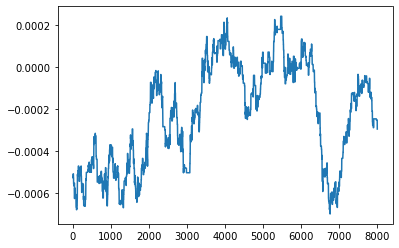

In [11]:
plt.plot(samples[:, 5])
plt.show()

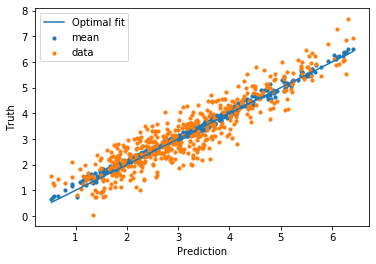

In [12]:
y_pred_array = y_pred.detach().numpy()
plt.scatter(y_pred_array, test_simulator.y_mean, label="mean", s=10)
plt.scatter(y_pred_array, test_simulator.y, label="data", s=10)
grid = np.linspace(np.min(y_pred_array), np.max(y_pred_array), 100)
plt.plot(grid, grid, label="Optimal fit")
plt.xlabel("Prediction")
plt.ylabel("Truth")
plt.legend()
#plt.savefig("HMC_nonlinear_fit.png")
plt.show()